<a href="https://colab.research.google.com/github/jhihan/Home-Credit-Default-Risk/blob/master/Home_Credit_Default_Risk_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

"Home Credit Default Risk" project with data exploratory analysis and manual feature engineering
==
This project is from the kaggle competition https://www.kaggle.com/c/home-credit-default-risk/overview and is a good project to deal with large relational database. Before dealing with the whole datasets, we do exploratory data analysis (EDA) with the focus on the main table first in order to understand the data. Then the whole feature engineering process on the full datasets is perfomed in file Home_Credit_Default_Risk.ipynb.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import seaborn
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR, SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import xgboost as xgb

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
uploaded = files.upload()

Saving application_test.csv to application_test.csv


In [0]:
train = pd.read_csv( "application_train.csv" )
test = pd.read_csv( "application_test.csv" )
print("train",train.shape)
print("test",test.shape)

train (307511, 122)
test (48744, 121)


In [0]:
print(train.dtypes)
print(test.dtypes)

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 122, dtype: object
SK_ID_CURR                      int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
FLAG_OWN_REALTY                object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 121, dtype: object


In [0]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,...,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.026392,-13976,-1866,-2000.0,-4208,NaN,1,1,0,1,1,0,Sales staff,4.0,2,2,WEDNESDAY,11,0,0,0,0,0,0,Business Entity Type 3,...,0.2446,0.3739,0.0388,0.0817,reg oper account,block of flats,0.3700,Panel,No,0.0,0.0,0.0,0.0,-1805.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010032,-13040,-2191,-4000.0,-4262,16.0,1,1,1,1,0,0,NaN,3.0,2,2,FRIDAY,5,0,0,0,0,1,1,Business Entity Type 3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-821.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Examine the Distribution of the Target Column inorder to check:
--
1. How many target values are there?

2. Is this the imbalance classification problem? (The distribution of the target data)

In [0]:
train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

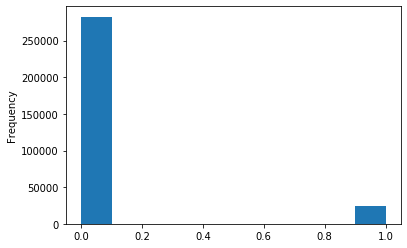

In [0]:
train['TARGET'].plot.hist();

Combine the train and the test data inorder to do further preprocessing

In [0]:
combine = train.append(test,ignore_index=True,sort=True)

In [0]:
missing_values = pd.DataFrame(columns = ["number","percentage"])
for var in combine.columns:
    if combine[var].isnull().sum()>0:
        missing_values.loc[var] = [ combine[var].isnull().sum() , combine[var].isnull().sum()/combine.shape[0] ]
missing_values.sort_values( 'percentage', ascending=False)

,number,percentage
COMMONAREA_AVG,248360.0,0.697141
COMMONAREA_MODE,248360.0,0.697141
COMMONAREA_MEDI,248360.0,0.697141
NONLIVINGAPARTMENTS_MODE,246861.0,0.692933
NONLIVINGAPARTMENTS_MEDI,246861.0,0.692933
...,...,...
EXT_SOURCE_2,668.0,0.001875
AMT_GOODS_PRICE,278.0,0.000780
AMT_ANNUITY,36.0,0.000101
CNT_FAM_MEMBERS,2.0,0.000006


In [0]:
combine.dtypes.value_counts()

float64    66
int64      40
object     16
dtype: int64

In [0]:
categorical = [var for var in combine.columns if combine[var].dtype=='O']
numerical = [var for var in combine.columns if combine[var].dtype!='O']
print("There are ", len(categorical), " categorical features and ", len(numerical)," numerical features")

There are  16  categorical features and  106  numerical features


Data preprocessing: categotical data

In [0]:
for var in categorical:
    print(var,'% of missing', combine[var].isnull().sum()/combine.shape[0], 'categorical values: ', combine[var].unique())

CODE_GENDER % of missing 0.0 categorical values:  ['M' 'F' 'XNA']
EMERGENCYSTATE_MODE % of missing 0.4714712775961039 categorical values:  ['No' nan 'Yes']
FLAG_OWN_CAR % of missing 0.0 categorical values:  ['N' 'Y']
FLAG_OWN_REALTY % of missing 0.0 categorical values:  ['Y' 'N']
FONDKAPREMONT_MODE % of missing 0.6823539318746403 categorical values:  ['reg oper account' nan 'org spec account' 'reg oper spec account'
 'not specified']
HOUSETYPE_MODE % of missing 0.4994063241217667 categorical values:  ['block of flats' nan 'terraced house' 'specific housing']
NAME_CONTRACT_TYPE % of missing 0.0 categorical values:  ['Cash loans' 'Revolving loans']
NAME_EDUCATION_TYPE % of missing 0.0 categorical values:  ['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
NAME_FAMILY_STATUS % of missing 0.0 categorical values:  ['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']
NAME_HOUSING_TYPE % of missing 0.0 ca

Now we will fill the missing data of the categorical features, and then convert categorical data into numerical data using Label-Encoder and One-Hot-Encoder. It is worth noting that there is a feature "WEEKDAY_APPR_PROCESS_START" in which the values have periodic nature, so we should convert the weekday to real number and then to sin & cos in order to keep the periodicity.

In [0]:
for var in categorical:
  combine[var].fillna('NA', inplace=True)

In [0]:
categorical.remove('WEEKDAY_APPR_PROCESS_START')
ohe = OneHotEncoder(handle_unknown="ignore", sparse = False)
transformed_array = ohe.fit_transform(combine[categorical].values)    

In [0]:
ohe.categories_

[array(['F', 'M', 'XNA'], dtype=object),
 array(['NA', 'No', 'Yes'], dtype=object),
 array(['N', 'Y'], dtype=object),
 array(['N', 'Y'], dtype=object),
 array(['NA', 'not specified', 'org spec account', 'reg oper account',
        'reg oper spec account'], dtype=object),
 array(['NA', 'block of flats', 'specific housing', 'terraced house'],
       dtype=object),
 array(['Cash loans', 'Revolving loans'], dtype=object),
 array(['Academic degree', 'Higher education', 'Incomplete higher',
        'Lower secondary', 'Secondary / secondary special'], dtype=object),
 array(['Civil marriage', 'Married', 'Separated', 'Single / not married',
        'Unknown', 'Widow'], dtype=object),
 array(['Co-op apartment', 'House / apartment', 'Municipal apartment',
        'Office apartment', 'Rented apartment', 'With parents'],
       dtype=object),
 array(['Businessman', 'Commercial associate', 'Maternity leave',
        'Pensioner', 'State servant', 'Student', 'Unemployed', 'Working'],
       dtype=obje

In [0]:
oneHotFeature = ohe.get_feature_names(categorical)

In [0]:
df_transform = pd.DataFrame(transformed_array, columns=oneHotFeature)

In [0]:
combine.columns

Index(['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       ...
       'TARGET', 'TOTALAREA_MODE', 'WALLSMATERIAL_MODE',
       'WEEKDAY_APPR_PROCESS_START', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BEGINEXPLUATATION_MODE',
       'YEARS_BUILD_AVG', 'YEARS_BUILD_MEDI', 'YEARS_BUILD_MODE'],
      dtype='object', length=122)

In [0]:
combine = pd.concat([combine, df_transform.reindex(combine.index)], axis=1)

In [0]:
combine

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,COMMONAREA_AVG,COMMONAREA_MEDI,COMMONAREA_MODE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,ELEVATORS_AVG,ELEVATORS_MEDI,ELEVATORS_MODE,EMERGENCYSTATE_MODE,ENTRANCES_AVG,ENTRANCES_MEDI,ENTRANCES_MODE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,...,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_NA,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0247,0.0250,0.0252,0.0369,0.0369,0.0383,0,1.0,M,0.0143,0.0144,0.0144,-9461,-637,-2120,-1134.0,-3648.0,2.0,2.0,0.00,0.00,0.0000,No,0.0690,0.0690,0.0690,0.083037,0.262949,0.139376,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0959,0.0968,0.0924,0.0529,0.0529,0.0538,0,2.0,F,0.0605,0.0608,0.0497,-16765,-1188,-291,-828.0,-1186.0,0.0,0.0,0.08,0.08,0.0806,No,0.0345,0.0345,0.0345,0.311267,0.622246,NaN,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,M,NaN,NaN,NaN,-19046,-225,-2531,-815.0,-4260.0,0.0,0.0,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,0.555912,0.729567,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2.0,F,NaN,NaN,NaN,-19005,-3039,-2437,-617.0,-9833.0,0.0,0.0,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,0.650442,NaN,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,M,NaN,NaN,NaN,-19932,-3038,-3458,-1106.0,-4311.0,0.0,0.0,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,0.322738,NaN,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [0]:
def weekday_map(x):
  WEEKDAY_MAP = {'SUNDAY':0,'MONDAY':1,'TUESDAY':2,'WEDNESDAY':3,'THURSDAY':4,'FRIDAY':5,'SATURDAY':6}
  return WEEKDAY_MAP[x]

In [0]:
combine['WEEKDAY_APPR_PROCESS_START_COS'] = np.cos( combine['WEEKDAY_APPR_PROCESS_START'].apply(weekday_map) * 2*np.pi/7 )
combine['WEEKDAY_APPR_PROCESS_START_SIN'] = np.sin( combine['WEEKDAY_APPR_PROCESS_START'].apply(weekday_map) * 2*np.pi/7 )

Data preprocessing: numerical data

In [0]:
numerical_missing=[]
for var in numerical:
    print(var,'% of missing', combine[var].isnull().sum()/combine.shape[0])
    if( combine[var].isnull().sum()>0 and var!="TARGET"):
      numerical_missing.append(var)

AMT_ANNUITY % of missing 0.00010105121331630434
AMT_CREDIT % of missing 0.0
AMT_GOODS_PRICE % of missing 0.0007803399250536834
AMT_INCOME_TOTAL % of missing 0.0
AMT_REQ_CREDIT_BUREAU_DAY % of missing 0.13352233652861012
AMT_REQ_CREDIT_BUREAU_HOUR % of missing 0.13352233652861012
AMT_REQ_CREDIT_BUREAU_MON % of missing 0.13352233652861012
AMT_REQ_CREDIT_BUREAU_QRT % of missing 0.13352233652861012
AMT_REQ_CREDIT_BUREAU_WEEK % of missing 0.13352233652861012
AMT_REQ_CREDIT_BUREAU_YEAR % of missing 0.13352233652861012
APARTMENTS_AVG % of missing 0.5051101037178426
APARTMENTS_MEDI % of missing 0.5051101037178426
APARTMENTS_MODE % of missing 0.5051101037178426
BASEMENTAREA_AVG % of missing 0.5826837518069922
BASEMENTAREA_MEDI % of missing 0.5826837518069922
BASEMENTAREA_MODE % of missing 0.5826837518069922
CNT_CHILDREN % of missing 0.0
CNT_FAM_MEMBERS % of missing 5.613956295350241e-06
COMMONAREA_AVG % of missing 0.6971410927565929
COMMONAREA_MEDI % of missing 0.6971410927565929
COMMONAREA_MOD

Check which features might be discrete numerical data.

In [0]:
for var in numerical:
    print(var,'# of values: ', len(combine[var].unique()) )

AMT_ANNUITY # of values:  14167
AMT_CREDIT # of values:  6480
AMT_GOODS_PRICE # of values:  1292
AMT_INCOME_TOTAL # of values:  2741
AMT_REQ_CREDIT_BUREAU_DAY # of values:  10
AMT_REQ_CREDIT_BUREAU_HOUR # of values:  6
AMT_REQ_CREDIT_BUREAU_MON # of values:  25
AMT_REQ_CREDIT_BUREAU_QRT # of values:  12
AMT_REQ_CREDIT_BUREAU_WEEK # of values:  10
AMT_REQ_CREDIT_BUREAU_YEAR # of values:  26
APARTMENTS_AVG # of values:  2392
APARTMENTS_MEDI # of values:  1164
APARTMENTS_MODE # of values:  771
BASEMENTAREA_AVG # of values:  3832
BASEMENTAREA_MEDI # of values:  3822
BASEMENTAREA_MODE # of values:  3892
CNT_CHILDREN # of values:  16
CNT_FAM_MEMBERS # of values:  19
COMMONAREA_AVG # of values:  3272
COMMONAREA_MEDI # of values:  3290
COMMONAREA_MODE # of values:  3216
DAYS_BIRTH # of values:  17467
DAYS_EMPLOYED # of values:  12896
DAYS_ID_PUBLISH # of values:  6224
DAYS_LAST_PHONE_CHANGE # of values:  3847
DAYS_REGISTRATION # of values:  15898
DEF_30_CNT_SOCIAL_CIRCLE # of values:  11
DEF_6

In [0]:
combine['HOUR_APPR_PROCESS_START'].unique()

array([10, 11,  9, 17, 16, 14,  8, 15,  7, 13,  6, 12, 19,  3, 18, 21,  4,
        5, 20, 22,  1,  2, 23,  0])

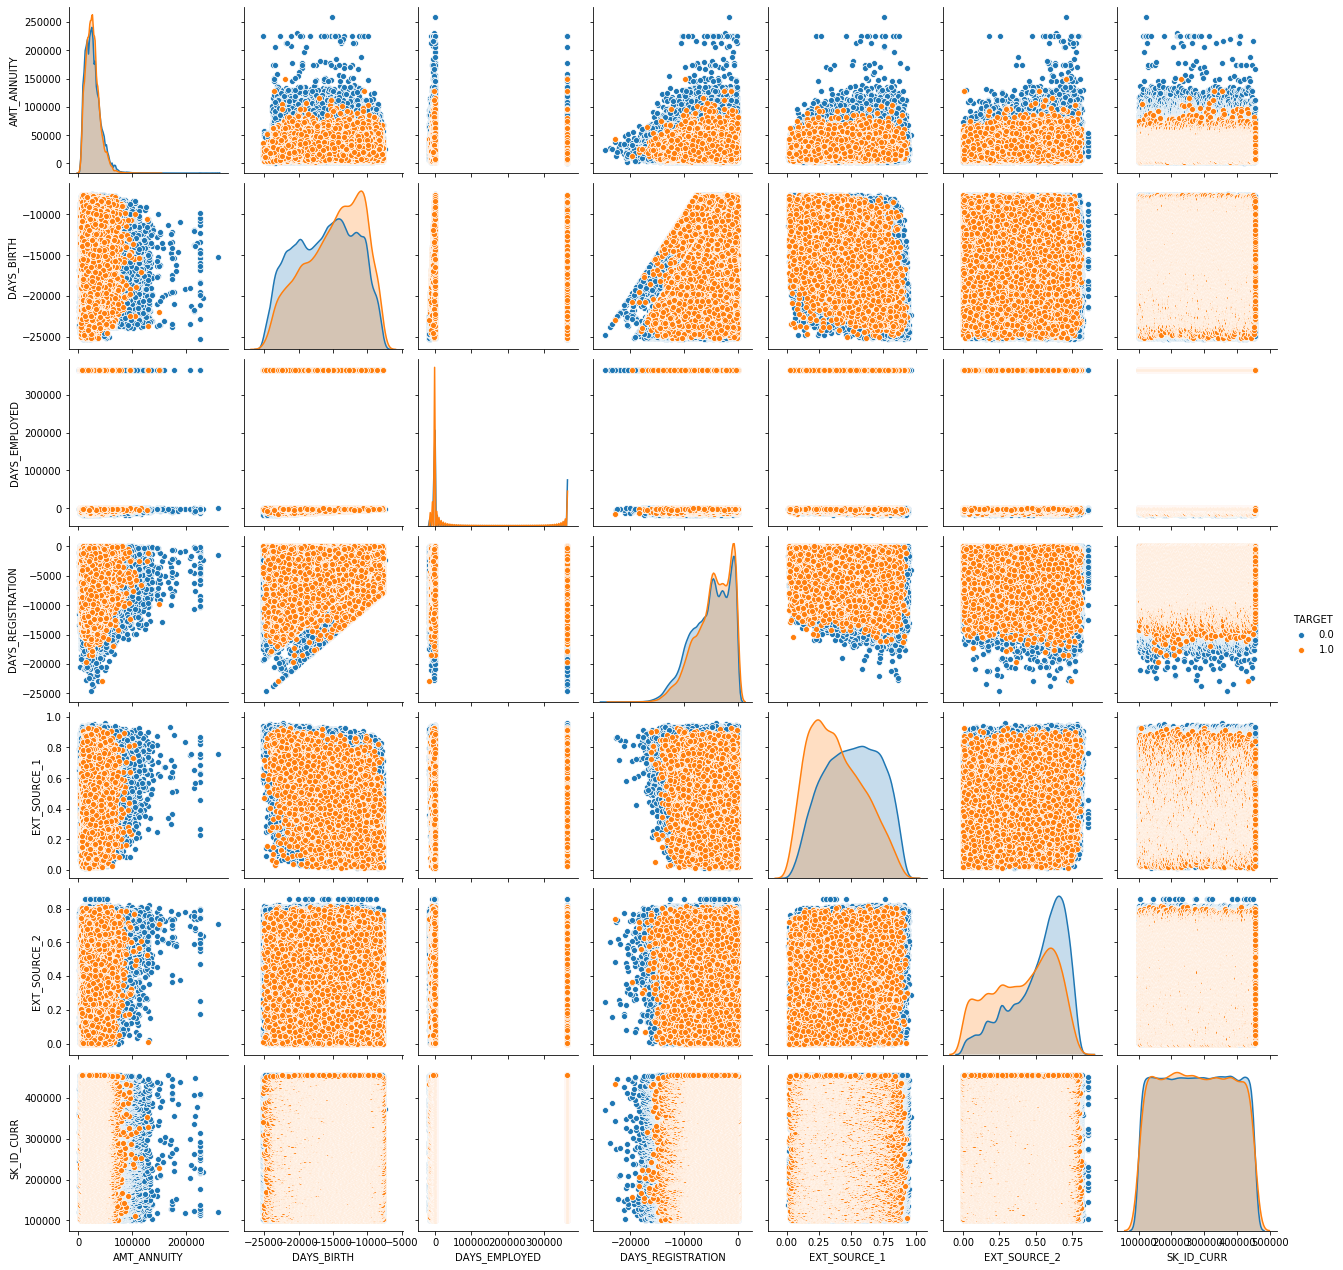

In [0]:
continuous=[]
for var in numerical:
  if (len( combine[var].unique() ) > 10000):
    continuous.append(var)
seaborn.pairplot( combine[continuous+['TARGET']], hue='TARGET' )

From the above polot, we realize that the feature "DAYS_EMPLOYED" looks strange because there is outlier at very large number (more than 300000 days => more than 100 years)... We can also realize that DAY_EMPLOYED must larger than DAY_REGISTRATION. Therefore, we will check the pairplot between different day-realted features. Before we do that, we would like to transform the outlier of "DAYS_EMPLOYED" to nan...

In [0]:
print( len( train[train['DAYS_EMPLOYED']>300000]['DAYS_EMPLOYED'].unique() ) )

1


In [0]:
 train[train['DAYS_EMPLOYED']>300000]['DAYS_EMPLOYED'].unique()

array([365243])

Now we know there is data anomoly at train['DAYS_EMPLOYED'] == 365243... 365243-day means 1000-year.

In [0]:
train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

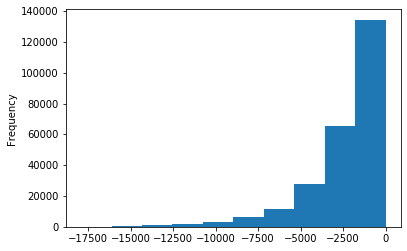

In [0]:
train['DAYS_EMPLOYED'].plot.hist()

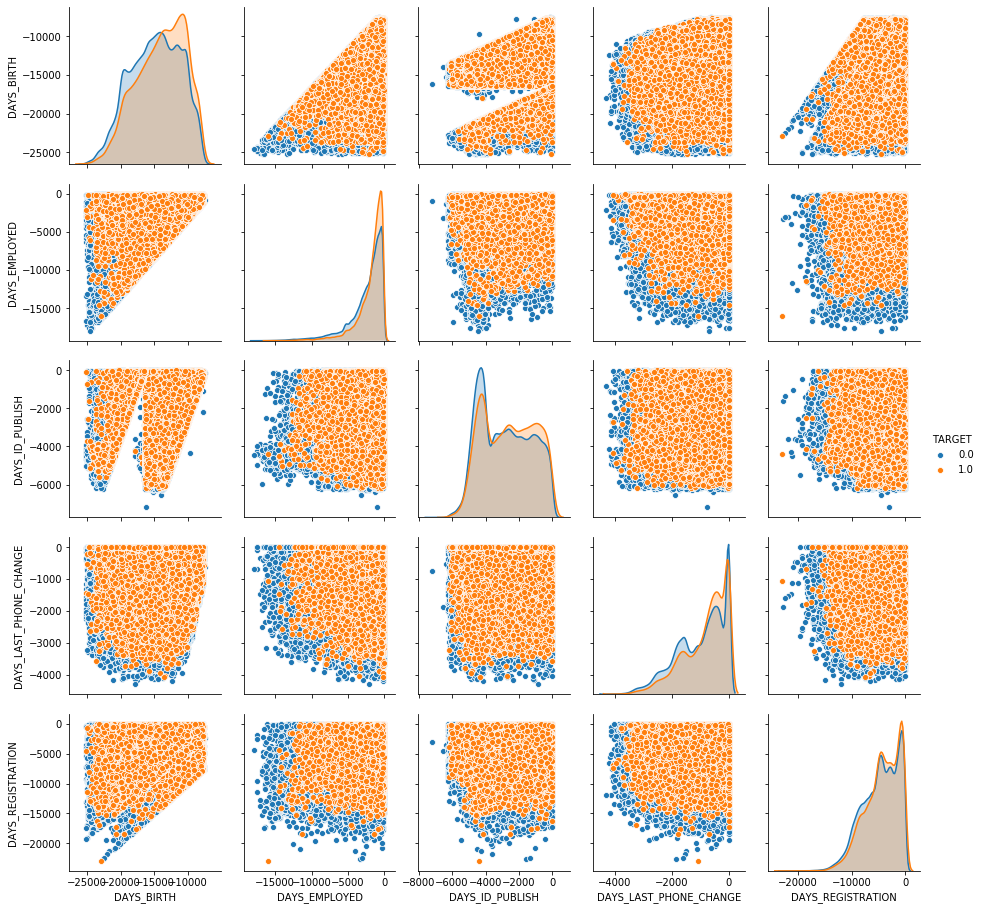

In [0]:
days_feature = ['DAYS_BIRTH','DAYS_EMPLOYED','DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE','DAYS_REGISTRATION']
seaborn.pairplot( combine[ combine['DAYS_EMPLOYED']<300000 ][days_feature + ['TARGET']], hue='TARGET' )


Translate the hour information to periodic data

In [0]:
combine['HOUR_APPR_PROCESS_START_COS'] = np.cos( combine['HOUR_APPR_PROCESS_START'] * 2*np.pi/24 )
combine['HOUR_APPR_PROCESS_START_SIN'] = np.sin( combine['HOUR_APPR_PROCESS_START'] * 2*np.pi/24 )

Fill the missing data and then create a new feature to label whether the data with a specific feature is missing.

In [0]:
for var in numerical_missing:
  combine[var+'_NA'] = np.where(combine[var].isnull(), 1, 0)
  combine[var].fillna(combine[var].median(), inplace=True)

In [0]:
for var in combine.columns:
  if(combine[var].isnull().sum()>0):
    print(var,'% of missing', combine[var].isnull().sum()/combine.shape[0])

TARGET % of missing 0.13682334283027606


In [0]:
feature_train = []
for var in combine.columns:
  if( (var not in categorical) and (var!='TARGET') and (var!='HOUR_APPR_PROCESS_START') and (var!='WEEKDAY_APPR_PROCESS_START')):
    feature_train.append(var)

Split train and test data

In [0]:
train_data = combine.loc[~combine.TARGET.isna()]
test_data = combine.loc[~combine.TARGET.isna()]

In [0]:
X_train, X_test, y_train, y_test = train_test_split( train_data[feature_train] ,train_data.TARGET, test_size=0.15, random_state=42)

Train the data

In [0]:
lr_pipe = Pipeline( [ ('std', StandardScaler()) , ('lr', LogisticRegression() ) ] )
lr = {
    'estimator' : lr_pipe,
    'param_grid' : 
#    {'lr__C': [1e-3]}
    {'lr__C': [1e-1, 1e0, 1e1, 1e2]}
} 

rfc = {
    'estimator' : RandomForestClassifier(random_state=1),
    'param_grid' : 
    {'max_depth': [11, 13, 15]}
} 

xgbc = {
    'estimator' : xgb.XGBClassifier(),
    'param_grid' : 
    {
       'max_depth': [3 , 5, 7, 9],
       'min_child_weight' : [3 , 5]
    }
}

svm_pipe = Pipeline( [ ('std', StandardScaler()) , ('svm', SVC() ) ] )
svm = {
    'estimator' : svm_pipe,
    'param_grid' : 
    {'svm__kernel': ['rbf'],
#     'svm__C': [1e-3,1e-1,1e0, 1e1, 1e2],
     'svm__C': [1e-1,1e0, 1e1],
     'svm__gamma' : [1e-3, 1e-2 ],
     'svm__class_weight' : [{ 0:0.5, 1:0.5 },{ 0:0.3, 1:0.7 },{ 0:0.1, 1:0.9 }],
     'svm__probability' : ['True'],
     'svm__max_iter': [100]
     }
}

model_sets = [lr,rfc,svm]

model_gridSearchCV = []
for item in model_sets[0:1]:
  model_gridSearchCV.append( GridSearchCV(**item, scoring  = 'roc_auc', cv = 10, n_jobs=-1) )

for item in model_gridSearchCV[0:1]:
  item.fit( X_train, y_train )

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [0]:
for item in model_gridSearchCV[0:1]:
  print(item.best_params_)
  print(item.best_score_)
  print(item.cv_results_)

{'lr__C': 10.0}
0.7473349061248795
{'mean_fit_time': array([27.46473062, 27.0255039 , 26.7764895 , 26.67333224]), 'std_fit_time': array([0.54423623, 0.4526058 , 0.40033569, 0.28664624]), 'mean_score_time': array([0.11230054, 0.10606444, 0.10804424, 0.0935432 ]), 'std_score_time': array([0.0152372 , 0.00616231, 0.00734154, 0.01384169]), 'param_lr__C': masked_array(data=[0.1, 1.0, 10.0, 100.0],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'lr__C': 0.1}, {'lr__C': 1.0}, {'lr__C': 10.0}, {'lr__C': 100.0}], 'split0_test_score': array([0.74868973, 0.74850551, 0.74853729, 0.74842949]), 'split1_test_score': array([0.75258971, 0.75266512, 0.75275586, 0.75274995]), 'split2_test_score': array([0.74774365, 0.74777663, 0.74784041, 0.74788166]), 'split3_test_score': array([0.75050373, 0.7503363 , 0.75037318, 0.75034925]), 'split4_test_score': array([0.74246685, 0.74239726, 0.74239688, 0.74236593]), 'split5_test_score': array([0.7373899

In [0]:
for item in model_gridSearchCV[0:1]:
  y_pred = item.predict(X_test)
  y_pred_pro = item.predict_proba(X_test)[:,1]
  roc_auc = roc_auc_score(y_true=y_test, y_score= y_pred_pro)
  accuracy = accuracy_score(y_true=y_test, y_pred= y_pred)
  print('roc_auc:',roc_auc,',accuracy:',accuracy)

The predicted roc_auc is about 0.74